# Data prep more  time wind
This is a notebook to read in raw datasets and transform them into datasets for a neural network. Only 10m above surface wind. <br>
Steps done:<br>

    - Interpolating WRF parts to same grid and extent
    - Interpolating NCEP to WRF 3km grid
    - Coarsening WRF 9km back to its original grid from the 3km grid
    - Coarsening NCEP to an 18km grid from the 3km grid
    - Writing data to .tfrecord files
    - Future Test same steps as before

In [1]:
# data
import netCDF4 as nc
import numpy as np

import pandas as pd

# models 
import tensorflow as tf
print(tf.__version__)

tf.compat.v1.enable_eager_execution()

# must be True
print(tf.executing_eagerly())

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import os

import helper_functions as hf
from skimage.metrics import structural_similarity as ssim

import importlib as imp

2.8.0
True


Module helper_functions contains self-made and are kept there to make this document more readable. To reload the module after changes to any of its functions use the imp.reload(hf) function below.

In [2]:
imp.reload(hf)

<module 'helper_functions' from 'E:\\Universiteit\\Jaar_6\\Master_Thesis_Part_2\\Sebastian_modified_software\\helper_functions.py'>

### Reading in the datasets

#### WRF 9 KM

In [3]:
# coordinates

c1 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LAT_Garda_d01_part1.nc')
c2 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LON_Garda_d01_part1.nc')

c3 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LAT_Garda_d01_part2.nc')
c4 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LON_Garda_d01_part2.nc')

lat_WRF_9km_part1 = np.array(c1['XLAT'][0])
lon_WRF_9km_part1 = np.array(c2['XLONG'][0])

lat_WRF_9km_part2 = np.array(c3['XLAT'][0])
lon_WRF_9km_part2 = np.array(c4['XLONG'][0])

In [4]:
# data
ds1 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/U10_Garda_d01_part1.nc')
ds2 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/U10_Garda_d01_part2.nc')

ds3 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/V10_Garda_d01_part1.nc')
ds4 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/V10_Garda_d01_part2.nc')

# u-component of wind
U_WRF_9km_part1 = np.array(ds1['U10'])
U_WRF_9km_part2 = np.array(ds2['U10'])

# v-component of wind
V_WRF_9km_part1 = np.array(ds3['V10'])
V_WRF_9km_part2 = np.array(ds4['V10'])

In [5]:
U_WRF_9km_part1.shape, U_WRF_9km_part2.shape #(1552, 31, 26)

((1552, 31, 26), (13064, 31, 26))

#### WRF 3 km

In [6]:
c5 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LAT_Garda_d02_part1.nc')
c6 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LON_Garda_d02_part1.nc')

c7 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LAT_Garda_d02_part2.nc')
c8 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LON_Garda_d02_part2.nc')

lat_WRF_3km_part1 = np.array(c5['XLAT'][0])[:,0:96]
lon_WRF_3km_part1 = np.array(c6['XLONG'][0])[:,0:96]

lat_WRF_3km_part2 = np.array(c7['XLAT'][0])
lon_WRF_3km_part2 = np.array(c8['XLONG'][0])

print(lon_WRF_3km_part1.shape)

(31, 31)


In [7]:
# data
ds5 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/U10_Garda_d02_part1.nc')
ds6 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/U10_Garda_d02_part2.nc')

ds7 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/V10_Garda_d02_part1.nc')
ds8 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/V10_Garda_d02_part2.nc')

# u-component of wind
U_WRF_3km_part1 = np.array(ds5['U10'])[:,:,0:96]
U_WRF_3km_part2 = np.array(ds6['U10'])

# v-component of wind
V_WRF_3km_part1 = np.array(ds7['V10'])[:,:,0:96]
V_WRF_3km_part2 = np.array(ds8['V10'])

U_WRF_3km_part1.shape, U_WRF_3km_part2.shape

((1544, 31, 31), (13072, 31, 31))

#### WRF Test data

In [8]:
#Test 2021

#9km
U_WRF_9km_2021 = U_WRF_9km_part2[10136:13056,:,:] #8 indices to much, because 5 years should have 14608 (1 year = 2920 indices)
V_WRF_9km_2021 = V_WRF_9km_part2[10136:13056,:,:]

#3km
U_WRF_3km_2021 = U_WRF_3km_part2[10144:13064,:,:] #other indices because part 2 of d02 is not the same as d01
V_WRF_3km_2021 = V_WRF_3km_part2[10144:13064,:,:]

print(U_WRF_3km_2021.shape, U_WRF_9km_2021.shape)

#Train part2

#9km
U_WRF_9km_part2_train = U_WRF_9km_part2[0:10136,:,:]
V_WRF_9km_part2_train = V_WRF_9km_part2[0:10136,:,:]

#3km
U_WRF_3km_part2_train = U_WRF_3km_part2[0:10144,:,:]
V_WRF_3km_part2_train = V_WRF_3km_part2[0:10144,:,:]


print(U_WRF_3km_part2_train.shape, U_WRF_9km_part2_train.shape)


(2920, 31, 31) (2920, 31, 26)
(10144, 31, 31) (10136, 31, 26)


#### NCEP GFS dataset

In [9]:
#data
ds_wind_NCEP = nc.Dataset('F:/Master_Thesis/Data/NCEP data/More_Training_data/U10_V10/NCEP_U10_V10_2017_2021.nc')
U_NCEP = ds_wind_NCEP['U_GRD_L103']
V_NCEP = ds_wind_NCEP['V_GRD_L103']


#coordinates
lat_NCEP = np.array(ds_wind_NCEP['lat'])
lon_NCEP = np.array(ds_wind_NCEP['lon'])

print(U_NCEP.shape)
print(lon_NCEP)
np.array(ds_wind_NCEP['time'])


(14614, 17, 25)
[ 8.    8.25  8.5   8.75  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75
 11.   11.25 11.5  11.75 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75
 14.  ]


array([    0,     3,     6, ..., 43839, 43842, 43845], dtype=int64)

In [10]:
if(len(lat_NCEP.shape)==1):
    lon_NCEP, lat_NCEP = np.meshgrid(lon_NCEP, lat_NCEP)

lon_NCEP.shape

(17, 25)

NCEP test

In [11]:
#test 2021
U_NCEP_2021 = U_NCEP[11688:14608,:,:]
V_NCEP_2021 = V_NCEP[11688:14608,:,:]

#train 2017-2020
U_NCEP_train = U_NCEP[0:11688,:,:]
V_NCEP_train = V_NCEP[0:11688,:,:]

U_NCEP_train.shape, U_NCEP_2021.shape


((11688, 17, 25), (2920, 17, 25))

#### Time

For time data I used a season index using the following short algorithm. Time and elevation data was not used in the final model since to use any metadata in this model one would need to stack the data.  Stacking different variables does require min-max normalisation to have the different variables on the same scale. But this resulted in low performance since the final produced superresolutions are on a different scale.

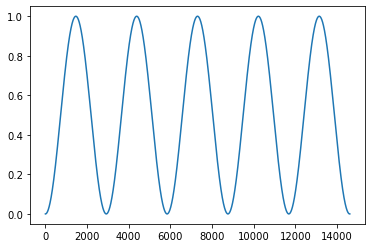

In [13]:
import math as m

time = []

for t in range(14608):
    time.append(m.sin(m.pi*t/2920)**2)
    
plt.plot(time)
plt.show()

In [14]:
time_arr = np.zeros((14608,96,96),dtype='float32')
for t in range(time_arr.shape[0]):
    time_arr[t,:,:] = time[t]

time_arr.shape

(14608, 96, 96)

### Interpolating to same extent

This is done by changing longitude and latitude coordinates of the datasets to a cartesian grid and using nearest neighbor interpolation to get all data on the same grid (WRF 3km).

In [15]:
# target cartesian coordinates
xt, yt, zt = hf.lon_lat_to_cartesian(lon_WRF_3km_part1.flatten(), lat_WRF_3km_part1.flatten())

#### WRF 9 km

In [16]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_WRF_9km_part1.flatten(), lat_WRF_9km_part1.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [17]:
# nearest neighbor
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

U_WRF_9km_part1_near = hf.transform_extent(U_WRF_9km_part1, inds, lat_WRF_3km_part1.shape)
V_WRF_9km_part1_near = hf.transform_extent(V_WRF_9km_part1, inds, lat_WRF_3km_part1.shape)

In [18]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_WRF_9km_part2.flatten(), lat_WRF_9km_part2.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [19]:
# nearest neighbor
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

U_WRF_9km_part2_near = hf.transform_extent(U_WRF_9km_part2_train, inds, lat_WRF_3km_part1.shape)
V_WRF_9km_part2_near = hf.transform_extent(V_WRF_9km_part2_train, inds, lat_WRF_3km_part1.shape)

Concatenating the two 9km WRF datasets to 1

In [20]:
U_WRF_9km_train = np.concatenate((U_WRF_9km_part1_near, U_WRF_9km_part2_near))
V_WRF_9km_train = np.concatenate((V_WRF_9km_part1_near, V_WRF_9km_part2_near))

print(U_WRF_9km_train.shape)

(11688, 31, 31)


Test data 9 km

In [21]:
U_WRF_9km_test = hf.transform_extent(U_WRF_9km_2021, inds, lat_WRF_3km_part1.shape)
V_WRF_9km_test = hf.transform_extent(V_WRF_9km_2021, inds, lat_WRF_3km_part1.shape)

U_WRF_9km_test.shape

(2920, 31, 31)

#### WRF 3km

In [22]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_WRF_3km_part2.flatten(), lat_WRF_3km_part2.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [23]:
# nearest neighbor
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

U_WRF_3km_part2_near = hf.transform_extent(U_WRF_3km_part2_train, inds, lat_WRF_3km_part1.shape)
V_WRF_3km_part2_near = hf.transform_extent(V_WRF_3km_part2_train, inds, lat_WRF_3km_part1.shape)

Concatenating the two 3km WRF datasets to 1

In [24]:
U_WRF_3km = np.concatenate((U_WRF_3km_part1, U_WRF_3km_part2_near))
V_WRF_3km = np.concatenate((V_WRF_3km_part1, V_WRF_3km_part2_near))

Test data 3km

In [25]:
U_WRF_3km_test = hf.transform_extent(U_WRF_3km_2021, inds, lat_WRF_3km_part1.shape)
V_WRF_3km_test = hf.transform_extent(V_WRF_3km_2021, inds, lat_WRF_3km_part1.shape)

U_WRF_3km_test.shape

(2920, 31, 31)

#### NCEP

In [26]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_NCEP.flatten(), lat_NCEP.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [27]:
# nearest neighbour
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

U_NCEP_near = hf.transform_extent(U_NCEP_train, inds, lat_WRF_3km_part1.shape)[0:U_WRF_9km_train.shape[0]]
V_NCEP_near = hf.transform_extent(V_NCEP_train, inds, lat_WRF_3km_part1.shape)[0:U_WRF_9km_train.shape[0]]


NCEP test

In [28]:
xs, ys, zs = hf.lon_lat_to_cartesian(lon_NCEP.flatten(), lat_NCEP.flatten())

tree = hf.cKDTree(np.column_stack((xs, ys, zs)))

In [29]:
# nearest neighbour
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

U_NCEP_test_near = hf.transform_extent(U_NCEP_2021, inds, lat_WRF_3km_part1.shape)[0:U_WRF_9km_test.shape[0]]
V_NCEP_test_near = hf.transform_extent(V_NCEP_2021, inds, lat_WRF_3km_part1.shape)[0:U_WRF_9km_test.shape[0]]

In [30]:
U_NCEP_test_near.shape

(2920, 31, 31)

#### Deleting raw datasets to save RAM space

In [31]:
del c1
del c2
del c3
del c4

In [32]:
del ds1, ds2, ds3, ds4#, ds5, ds6

In [33]:
#del T_WRF_9km_part1, T_WRF_9km_part2
del U_WRF_9km_part1, U_WRF_9km_part2
del V_WRF_9km_part1, V_WRF_9km_part2

In [34]:
#del T_WRF_3km_part1, T_WRF_3km_part2
del U_WRF_3km_part1, U_WRF_3km_part2
del V_WRF_3km_part1, V_WRF_3km_part2

In [35]:
del xs, xt, ys, yt, zs, zt
del d, inds

### Downscaling

Current model is doing downscaling by increasing the pixel count, so it wants a low pixel count image and increase the pixel count by an integer factor. For us the low resolution to medium resolution is 5x5 pixels to 10x10. And medium to high resolution is 10x10 to 30x30 (or 31x31). 

In [36]:
# Train
U_WRF_9km_down = hf.downscale_image(U_WRF_9km_train, 3)
V_WRF_9km_down = hf.downscale_image(V_WRF_9km_train, 3)

U_NCEP_down = hf.downscale_image(U_NCEP_near, 6)
V_NCEP_down = hf.downscale_image(V_NCEP_near, 6)


# Test
U_NCEP_test_down = hf.downscale_image(U_NCEP_test_near, 6)
V_NCEP_test_down = hf.downscale_image(V_NCEP_test_near, 6)

U_WRF_9km_down.shape, U_NCEP_down.shape, U_NCEP_test_down.shape

((11688, 10, 10, 1), (11688, 5, 5, 1), (2920, 5, 5, 1))

### Writing data to .npy for analysis

We should save the data to numpy arrays so we can read them later in analysis scripts.

In [37]:
# TRAIN

# WRF 3km

U_WRF_3km = U_WRF_3km[:, 0:30, 0:30]
V_WRF_3km = V_WRF_3km[:, 0:30, 0:30]

np.save('F:/Master_Thesis/Data/Analysis_More_Time/U_WRF_3km.npy', U_WRF_3km)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/V_WRF_3km.npy', V_WRF_3km)

# WRF 9km

np.save('F:/Master_Thesis/Data/Analysis_More_Time/U_WRF_9km.npy', U_WRF_9km_train)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/V_WRF_9km.npy', V_WRF_9km_train)

# NCEP native

np.save('F:/Master_Thesis/Data/Analysis_More_Time/U_NCEP_near.npy', U_NCEP_near)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/V_NCEP_near.npy', V_NCEP_near)

# NCEP down

np.save('F:/Master_Thesis/Data/Analysis_More_Time/U_NCEP_down.npy', U_NCEP_down)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/V_NCEP_down.npy', V_NCEP_down)



In [39]:
# TEST

# WRF 3km

U_WRF_3km_test = U_WRF_3km_test[:, 0:30, 0:30]
V_WRF_3km_test = V_WRF_3km_test[:, 0:30, 0:30]

np.save('F:/Master_Thesis/Data/Analysis_More_Time/U_WRF_3km_test.npy', U_WRF_3km_test)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/V_WRF_3km_test.npy', V_WRF_3km_test)

# WRF 9km

np.save('F:/Master_Thesis/Data/Analysis_More_Time/U_WRF_9km_test.npy', U_WRF_9km_test)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/V_WRF_9km_test.npy', V_WRF_9km_test)

# NCEP

# NCEP down

np.save('F:/Master_Thesis/Data/Analysis_More_Time/U_NCEP_test_down.npy', U_NCEP_test_down)
np.save('F:/Master_Thesis/Data/Analysis_More_Time/V_NCEP_test_down.npy', V_NCEP_test_down)

### Writing data to .tfrecord

The current model is implemented with reading data from a .tfrecord which is an Tensorflow data format.

#### Normal data sets

In [39]:
U_WRF_9km_down.shape

(11688, 10, 10, 1)

In [40]:
# Stacking wind data
Wind_WRF_9km = np.squeeze(np.stack([U_WRF_9km_down, V_WRF_9km_down], axis = -1))
Wind_NCEP = np.squeeze(np.stack([U_NCEP_down, V_NCEP_down], axis=-1))
Wind_NCEP_test = np.squeeze(np.stack([U_NCEP_test_down, V_NCEP_test_down], axis=-1))
    
print(Wind_WRF_9km.shape, Wind_NCEP.shape, Wind_NCEP_test.shape)

(11688, 10, 10, 2) (11688, 5, 5, 2) (2920, 5, 5, 2)


In [51]:
# Train
hf.generate_TFRecords(filename = 'F:/Master_Thesis/Data/TFRecords/More_Time/Wind_lr_mr.tfrecord',
                   data_HR = Wind_WRF_9km,
                   data_LR = Wind_NCEP,
                   mode = 'train')

# Test
hf.generate_TFRecords(filename = 'F:/Master_Thesis/Data/TFRecords/More_Time/Wind_lr_mr_test.tfrecord',
                   data_HR = None,
                   data_LR = Wind_NCEP_test,
                   mode = 'test')

#### Making MR - HR dataset

Stacking wind 3km components to a single array.

In [41]:
# Stacking wind data
Wind_WRF_3km = np.squeeze(np.stack([U_WRF_3km, V_WRF_3km], axis = -1))
Wind_WRF_3km_test = np.squeeze(np.stack([U_WRF_3km_test, V_WRF_3km_test], axis = -1))



print(Wind_WRF_3km.shape, Wind_WRF_3km_test.shape)

(11688, 30, 30, 2) (2920, 30, 30, 2)


In [42]:
# wind
Wind_mr = np.load('F:/Master_Thesis/Data/SR_data/More_Time/wind/LR_MR/dataSR.npy')      
Wind_mr_test = np.load('F:/Master_Thesis/Data/SR_data/More_Time/wind/LR_MR/test/dataSR.npy')

Wind_mr.shape, Wind_mr_test.shape

((11688, 10, 10, 2), (2920, 10, 10, 2))

Writing the generated MR and the 3km data to a .tfrecord dataset.

In [43]:
# Train
hf.generate_TFRecords(filename = 'F:/Master_Thesis/Data/TFRecords/More_Time/Wind_mr_hr.tfrecord',
                   data_HR = Wind_WRF_3km,
                   data_LR = Wind_mr,
                   mode = 'train')

# Test
hf.generate_TFRecords(filename = 'F:/Master_Thesis/Data/TFRecords/More_Time/Wind_mr_hr_test.tfrecord',
                   data_HR = None,
                   data_LR = Wind_mr_test,
                   mode = 'test')